# Naive Bayes

In [1]:
import csv
import random
import warnings
warnings.filterwarnings('ignore')

[(5.1, 1.4, '0'), (4.9, 1.4, '0'), (4.7, 1.3, '0'), (4.6, 1.5, '0'), (5.0, 1.4, '0'), (5.4, 1.7, '0'), (4.6, 1.4, '0'), (5.0, 1.5, '0'), (4.4, 1.4, '0'), (4.9, 1.5, '0'), (5.4, 1.5, '0'), (4.8, 1.6, '0'), (4.8, 1.4, '0'), (4.3, 1.1, '0'), (5.8, 1.2, '0'), (5.7, 1.5, '0'), (5.4, 1.3, '0'), (5.1, 1.4, '0'), (5.7, 1.7, '0'), (5.1, 1.5, '0'), (5.4, 1.7, '0'), (5.1, 1.5, '0'), (4.6, 1.0, '0'), (5.1, 1.7, '0'), (4.8, 1.9, '0'), (5.0, 1.6, '0'), (5.0, 1.6, '0'), (5.2, 1.5, '0'), (5.2, 1.4, '0'), (4.7, 1.6, '0'), (4.8, 1.6, '0'), (5.4, 1.5, '0'), (5.2, 1.5, '0'), (5.5, 1.4, '0'), (4.9, 1.5, '0'), (5.0, 1.2, '0'), (5.5, 1.3, '0'), (4.9, 1.5, '0'), (4.4, 1.3, '0'), (5.1, 1.5, '0'), (5.0, 1.3, '0'), (4.5, 1.3, '0'), (4.4, 1.3, '0'), (5.0, 1.6, '0'), (5.1, 1.9, '0'), (4.8, 1.4, '0'), (5.1, 1.6, '0'), (4.6, 1.4, '0'), (5.3, 1.5, '0'), (5.0, 1.4, '0'), (7.0, 4.7, '1'), (6.4, 4.5, '1'), (6.9, 4.9, '1'), (5.5, 4.0, '1'), (6.5, 4.6, '1'), (5.7, 4.5, '1'), (6.3, 4.7, '1'), (4.9, 3.3, '1'), (6.6, 4.6, '1

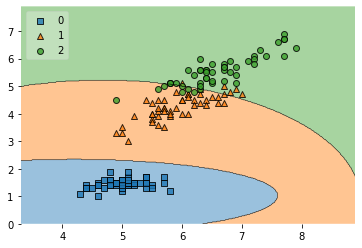

In [210]:
iris2dim = Classificador()

iris2dim.carregar('data/iris/iris2dim.csv', delimiter=',', ignoraLinha1=False)
print(iris2dim.dados)
iris2dim.treinar()
iris2dim.graficoFronteira()

In [211]:
class Classificador:
    dados = []
    modelo = {}
    
    def carregar(self, arquivo, delimiter=';', quoteChar='"', ignoraLinha1=True, ignoraColuna1=False):
        self.dados = []
        with open(arquivo) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=delimiter, quoting=csv.QUOTE_NONNUMERIC)
            if ignoraLinha1:
                next(csv_reader)                  
            for i, row in enumerate(csv_reader):
                if type(row[-1]) != str:
                    row[-1] = str(int(row[-1]))
                if ignoraColuna1:
                    self.dados.append(tuple(row[1:]))
                else:
                    self.dados.append(tuple(row))
    
    def treinar(self):
        total = len(self.dados)
        classes = list(set([x[-1] for x in self.dados]))
        combdata = {}
        pdata = {}
        for row in self.dados:
            classe = (row[-1])
            if classe in combdata:
                combdata[classe] += 1
            else:
                combdata[classe] = 1    
            for i, d in enumerate(row[:-1]):
                # variavel continua
                if (str(d).replace('.','',1).isdigit() or type(d) == float or type(d) == int):
                    ind = 'i'+str(i)
                    if ind in combdata:
                        combdata[ind].append(float(d))
                    else:
                        combdata[ind] = [ float(d) ]
                    key = (ind,classe)    
                    if key in combdata:
                        combdata[key].append(float(d))
                    else:
                        combdata[key] = [float(d)]
                # variavel nominal
                else:
                    if d in combdata:
                        combdata[d] += 1
                    else:
                        combdata[d] = 1
                    key = (d,classe)
                    if key in combdata:
                        combdata[key] += 1
                    else:
                        combdata[key] = 1
        # calculando probabilidades
        self.modelo = {}
        for c in combdata:
            if type(c) == tuple:
                if type(combdata[c]) != list:
                    self.modelo[c] = combdata[c] / combdata[c[1]]
                else:
                    media =  sum(combdata[c])/len(combdata[c])
                    desvio = (sum([(x-media)**2 for x in combdata[c]])/(len(combdata[c])-1))**0.5
                    self.modelo[c] = {
                        'media' : media,
                        'desvio' : desvio
                    }
            else:
                if type(combdata[c]) != list:
                    self.modelo[c] = combdata[c] / total
                else:
                    media =  sum(combdata[c])/len(combdata[c])
                    desvio = (sum([(x-media)**2 for x in combdata[c]])/(len(combdata[c])-1))**0.5
                    self.modelo[c] = {
                        'media' : media,
                        'desvio' : desvio
                    }
        self.modelo['classes'] = classes
    
    def g(self, qx, media, desvio):
        p1 = 1 / ( (2*3.141592653589793)**0.5 * desvio  )
        p2 = 2.718281828459045 ** (-((x - media) ** 2) / (2 * desvio ** 2))
        return p1 * p2
    
    
    def predizer(self, tupla, debug=False):
        probClasse = {}
        valClasse = 0
        maxClasse = ''
        for classe in self.modelo['classes']:
            numerador = 1
            denominador = 1
            #i=0
            for i, v in enumerate(tupla):
            #for v in tupla:
                #if type(v) == str:
                #if not str(v).replace('.','',1).isdigit():
                # atributo nominal
                if (not (str(v).replace('.','',1).isdigit() or type(v) in [float, np.float64, int])):
                    key = (v, classe)
                    if key in self.modelo:
                        numerador = numerador * self.modelo[key]
                    else:
                        numerador = numerador * 0.001
                    #if v in self.modelo:
                    denominador = denominador * self.modelo[v]
                    #else:
                    #denominador = denominador * 0.001
                # atributo continuo
                else:
                    v = float(v)
                    key1 = ('i'+str(i),classe)
                    key2 = 'i'+str(i)
                    #i += 1
                    if key1 in self.modelo:
                        numerador = numerador * g(v,self.modelo[key1]['media'],self.modelo[key1]['desvio'])
                    #else:
                    #    numerador = numerador * 0.001
                    denominador = denominador * g(v,self.modelo[key2]['media'],self.modelo[key2]['desvio'])
            numerador = numerador * self.modelo[classe]
            probClasse[classe] = numerador / denominador
            if debug:
                print(classe,probClasse[classe])
            if probClasse[classe] > valClasse:
                valClasse = probClasse[classe]
                maxClasse = classe
        return(maxClasse)    
    
    
    # método necessário para gerar gráfico
    def predict(self, tuplas):
        res = []
        for t in tuplas:
            res.append(int(self.predizer(t)))
        return(np.array(res))

    def graficoFronteira(self):
        X = np.array([ [float(x[0]),float(x[1])] for x in self.dados ])
        y = np.array([ int(float(x[2])) for x in self.dados ])
        plot_decision_regions(X, y, clf=self, legend=2)



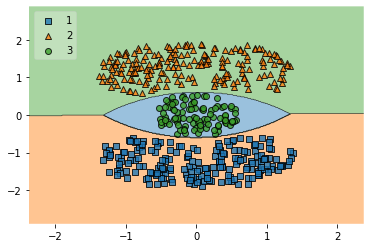

In [212]:
cassini = Classificador()
cassini.carregar('data/cassini500.csv', delimiter=',', ignoraColuna1=True)
cassini.dados
cassini.treinar()
cassini.graficoFronteira()

In [6]:
def validacaoCruzada(dados, porcentagem=0.7):
    random.shuffle(dados)
    dadosTreinamento = dados[:int(len(dados)*porcentagem)]
    dadosTestes = dados[int(len(dados)*porcentagem):]
    modelo = treinamento(dadosTreinamento)
    ok = 0
    for tupla in dadosTestes:
        #print(tupla[-1])
        tupl = [ float(x) for x in tupla[:-1]]
        tupl = tupla[:-1]
        #print(tupl)
        pred = verificar(modelo, tupl, debug=False) 
        #print('pred:',pred,'real:',tupla[-1])
        if pred == tupla[-1]:
            ok += 1
        #print()
    print('Conj Teste:',len(dadosTestes))
    print('Acertos   :',ok)
    print('Acurácia  : ',ok/len(dadosTestes)*100)


# dataset tempo

In [160]:
!head data/tempo.csv

"temp";"yesno"
"sunny";"no"
"overcast";"yes"
"rainny";"yes"
"sunny";"yes"
"sunny";"yes"
"overcast";"yes"
"rainny";"no"
"rainny";"no"
"sunny";"yes"


In [161]:
!wc -l data/tempo.csv

14 data/tempo.csv


In [162]:
tempo = Classificador()
tempo.carregar('data/tempo.csv')
print(len(tempo.dados))
tempo.dados

14


[('sunny', 'no'),
 ('overcast', 'yes'),
 ('rainny', 'yes'),
 ('sunny', 'yes'),
 ('sunny', 'yes'),
 ('overcast', 'yes'),
 ('rainny', 'no'),
 ('rainny', 'no'),
 ('sunny', 'yes'),
 ('rainny', 'yes'),
 ('sunny', 'no'),
 ('overcast', 'yes'),
 ('overcast', 'yes'),
 ('rainny', 'no')]

In [163]:
tempo.treinar()
tempo.modelo

{'no': 0.35714285714285715,
 'sunny': 0.35714285714285715,
 ('sunny', 'no'): 0.4,
 'yes': 0.6428571428571429,
 'overcast': 0.2857142857142857,
 ('overcast', 'yes'): 0.4444444444444444,
 'rainny': 0.35714285714285715,
 ('rainny', 'yes'): 0.2222222222222222,
 ('sunny', 'yes'): 0.3333333333333333,
 ('rainny', 'no'): 0.6,
 'classes': ['yes', 'no']}

In [164]:
tempo.predizer(['sunny'], debug=True)

yes 0.6
no 0.4


'yes'

In [165]:
tempo.predizer(['overcast'], debug=True)

yes 1.0
no 0.00125


'yes'

In [166]:
tempo.predizer(['rainny'], debug=True)

yes 0.39999999999999997
no 0.6


'no'

# dataset tenis

In [167]:
!head data/tenis.csv

"Aparência";"Temperatura";"Umidade";"Ventando";"Jogar"
"sol";"quente";"alta";"falso";"não"
"sol";"quente";"alta";"verdadeiro";"não"
"nublado";"quente";"alta";"falso";"sim"
"chuva";"agradável";"alta";"falso";"sim"
"chuva";"fria";"normal";"falso";"sim"
"chuva";"fria";"normal";"verdadeiro";"não"
"nublado";"fria";"normal";"verdadeiro";"sim"
"sol";"agradável";"alta";"falso";"não"
"sol";"fria";"normal";"falso";"sim"


In [14]:
!wc -l data/tenis.csv

14 data/tenis.csv


In [169]:
tenis = Classificador()
tenis.carregar('data/tenis.csv')
print(len(tenis.dados))
tenis.dados

14


[('sol', 'quente', 'alta', 'falso', 'não'),
 ('sol', 'quente', 'alta', 'verdadeiro', 'não'),
 ('nublado', 'quente', 'alta', 'falso', 'sim'),
 ('chuva', 'agradável', 'alta', 'falso', 'sim'),
 ('chuva', 'fria', 'normal', 'falso', 'sim'),
 ('chuva', 'fria', 'normal', 'verdadeiro', 'não'),
 ('nublado', 'fria', 'normal', 'verdadeiro', 'sim'),
 ('sol', 'agradável', 'alta', 'falso', 'não'),
 ('sol', 'fria', 'normal', 'falso', 'sim'),
 ('chuva', 'agradável', 'normal', 'falso', 'sim'),
 ('sol', 'agradável', 'normal', 'verdadeiro', 'sim'),
 ('nublado', 'agradável', 'alta', 'verdadeiro', 'sim'),
 ('nublado', 'quente', 'normal', 'falso', 'sim'),
 ('chuva', 'agradável', 'alta', 'verdadeiro', 'não')]

In [170]:
tenis.treinar()
tenis.modelo

{'não': 0.35714285714285715,
 'sol': 0.35714285714285715,
 ('sol', 'não'): 0.6,
 'quente': 0.2857142857142857,
 ('quente', 'não'): 0.4,
 'alta': 0.5,
 ('alta', 'não'): 0.8,
 'falso': 0.5714285714285714,
 ('falso', 'não'): 0.4,
 'verdadeiro': 0.42857142857142855,
 ('verdadeiro', 'não'): 0.6,
 'sim': 0.6428571428571429,
 'nublado': 0.2857142857142857,
 ('nublado', 'sim'): 0.4444444444444444,
 ('quente', 'sim'): 0.2222222222222222,
 ('alta', 'sim'): 0.3333333333333333,
 ('falso', 'sim'): 0.6666666666666666,
 'chuva': 0.35714285714285715,
 ('chuva', 'sim'): 0.3333333333333333,
 'agradável': 0.42857142857142855,
 ('agradável', 'sim'): 0.4444444444444444,
 'fria': 0.2857142857142857,
 ('fria', 'sim'): 0.3333333333333333,
 'normal': 0.5,
 ('normal', 'sim'): 0.6666666666666666,
 ('chuva', 'não'): 0.4,
 ('fria', 'não'): 0.2,
 ('normal', 'não'): 0.2,
 ('verdadeiro', 'sim'): 0.3333333333333333,
 ('agradável', 'não'): 0.4,
 ('sol', 'sim'): 0.2222222222222222,
 'classes': ['não', 'sim']}

In [171]:
tenis.predizer(['sol', 'fria', 'alta', 'verdadeiro'], debug=True)

não 0.9408
sim 0.2419753086419753


'não'

In [172]:
tenis.predizer(['chuva', 'fria', 'normal', 'verdadeiro'], debug=True)

não 0.15680000000000005
sim 0.7259259259259259


'sim'

# tenis2 dataset: atributos continuos

In [173]:
!head data/tenis2.csv

"Aparência";"Temperatura";"Umidade";"Ventando";"Jogar"
"sol";85;85;"falso";"não"
"sol";80;90;"verdadeiro";"não"
"nublado";83;86;"falso";"sim"
"chuva";70;96;"falso";"sim"
"chuva";68;80;"falso";"sim"
"chuva";65;70;"verdadeiro";"não"
"nublado";64;65;"verdadeiro";"sim"
"sol";72;95;"falso";"não"
"sol";69;70;"falso";"sim"


In [21]:
!wc -l data/tenis2.csv

14 data/tenis2.csv


In [174]:
tenis2 = Classificador()
tenis2.carregar('data/tenis2.csv')
print(len(tenis2.dados))
tenis2.dados

14


[('sol', 85.0, 85.0, 'falso', 'não'),
 ('sol', 80.0, 90.0, 'verdadeiro', 'não'),
 ('nublado', 83.0, 86.0, 'falso', 'sim'),
 ('chuva', 70.0, 96.0, 'falso', 'sim'),
 ('chuva', 68.0, 80.0, 'falso', 'sim'),
 ('chuva', 65.0, 70.0, 'verdadeiro', 'não'),
 ('nublado', 64.0, 65.0, 'verdadeiro', 'sim'),
 ('sol', 72.0, 95.0, 'falso', 'não'),
 ('sol', 69.0, 70.0, 'falso', 'sim'),
 ('chuva', 75.0, 80.0, 'falso', 'sim'),
 ('sol', 75.0, 70.0, 'verdadeiro', 'sim'),
 ('nublado', 72.0, 90.0, 'verdadeiro', 'sim'),
 ('nublado', 81.0, 75.0, 'falso', 'sim'),
 ('chuva', 71.0, 91.0, 'verdadeiro', 'não')]

In [175]:
tenis2.treinar()
tenis2.modelo

{'não': 0.35714285714285715,
 'sol': 0.35714285714285715,
 ('sol', 'não'): 0.6,
 'i1': {'media': 73.57142857142857, 'desvio': 6.57166745862975},
 ('i1', 'não'): {'media': 74.6, 'desvio': 7.893034904268446},
 'i2': {'media': 81.64285714285714, 'desvio': 10.285218242007035},
 ('i2', 'não'): {'media': 86.2, 'desvio': 9.731392500562292},
 'falso': 0.5714285714285714,
 ('falso', 'não'): 0.4,
 'verdadeiro': 0.42857142857142855,
 ('verdadeiro', 'não'): 0.6,
 'sim': 0.6428571428571429,
 'nublado': 0.2857142857142857,
 ('nublado', 'sim'): 0.4444444444444444,
 ('i1', 'sim'): {'media': 73.0, 'desvio': 6.164414002968976},
 ('i2', 'sim'): {'media': 79.11111111111111, 'desvio': 10.215728613814635},
 ('falso', 'sim'): 0.6666666666666666,
 'chuva': 0.35714285714285715,
 ('chuva', 'sim'): 0.3333333333333333,
 ('chuva', 'não'): 0.4,
 ('verdadeiro', 'sim'): 0.3333333333333333,
 ('sol', 'sim'): 0.2222222222222222,
 'classes': ['não', 'sim']}

In [176]:
tenis2.predizer(['sol', 83, 73, 'verdadeiro'], debug=True)

não 0.6661952433370804
sim 0.2984141388375451


'não'

# dataset iris

In [177]:
!head data/iris/iris.data

5.1,3.5,1.4,0.2,"Iris-setosa"
4.9,3.0,1.4,0.2,"Iris-setosa"
4.7,3.2,1.3,0.2,"Iris-setosa"
4.6,3.1,1.5,0.2,"Iris-setosa"
5.0,3.6,1.4,0.2,"Iris-setosa"
5.4,3.9,1.7,0.4,"Iris-setosa"
4.6,3.4,1.4,0.3,"Iris-setosa"
5.0,3.4,1.5,0.2,"Iris-setosa"
4.4,2.9,1.4,0.2,"Iris-setosa"
4.9,3.1,1.5,0.1,"Iris-setosa"


In [27]:
!wc -l data/iris/iris.data

149 data/iris/iris.data


In [180]:
iris = Classificador()
iris.carregar('data/iris/iris.data', delimiter=',', ignoraLinha1=False)
print(len(iris.dados))
iris.dados

150


[(5.1, 3.5, 1.4, 0.2, 'Iris-setosa'),
 (4.9, 3.0, 1.4, 0.2, 'Iris-setosa'),
 (4.7, 3.2, 1.3, 0.2, 'Iris-setosa'),
 (4.6, 3.1, 1.5, 0.2, 'Iris-setosa'),
 (5.0, 3.6, 1.4, 0.2, 'Iris-setosa'),
 (5.4, 3.9, 1.7, 0.4, 'Iris-setosa'),
 (4.6, 3.4, 1.4, 0.3, 'Iris-setosa'),
 (5.0, 3.4, 1.5, 0.2, 'Iris-setosa'),
 (4.4, 2.9, 1.4, 0.2, 'Iris-setosa'),
 (4.9, 3.1, 1.5, 0.1, 'Iris-setosa'),
 (5.4, 3.7, 1.5, 0.2, 'Iris-setosa'),
 (4.8, 3.4, 1.6, 0.2, 'Iris-setosa'),
 (4.8, 3.0, 1.4, 0.1, 'Iris-setosa'),
 (4.3, 3.0, 1.1, 0.1, 'Iris-setosa'),
 (5.8, 4.0, 1.2, 0.2, 'Iris-setosa'),
 (5.7, 4.4, 1.5, 0.4, 'Iris-setosa'),
 (5.4, 3.9, 1.3, 0.4, 'Iris-setosa'),
 (5.1, 3.5, 1.4, 0.3, 'Iris-setosa'),
 (5.7, 3.8, 1.7, 0.3, 'Iris-setosa'),
 (5.1, 3.8, 1.5, 0.3, 'Iris-setosa'),
 (5.4, 3.4, 1.7, 0.2, 'Iris-setosa'),
 (5.1, 3.7, 1.5, 0.4, 'Iris-setosa'),
 (4.6, 3.6, 1.0, 0.2, 'Iris-setosa'),
 (5.1, 3.3, 1.7, 0.5, 'Iris-setosa'),
 (4.8, 3.4, 1.9, 0.2, 'Iris-setosa'),
 (5.0, 3.0, 1.6, 0.2, 'Iris-setosa'),
 (5.0, 3.4, 

In [181]:
iris.treinar()
iris.modelo

{'Iris-setosa': 0.3333333333333333,
 'i0': {'media': 5.843333333333335, 'desvio': 0.8280661279778629},
 ('i0', 'Iris-setosa'): {'media': 5.005999999999999,
  'desvio': 0.3524896872134512},
 'i1': {'media': 3.0540000000000007, 'desvio': 0.4335943113621737},
 ('i1', 'Iris-setosa'): {'media': 3.4180000000000006,
  'desvio': 0.38102439795469095},
 'i2': {'media': 3.7586666666666693, 'desvio': 1.7644204199522617},
 ('i2', 'Iris-setosa'): {'media': 1.464, 'desvio': 0.1735111594364455},
 'i3': {'media': 1.1986666666666672, 'desvio': 0.7631607417008414},
 ('i3', 'Iris-setosa'): {'media': 0.2439999999999999,
  'desvio': 0.10720950308167837},
 'Iris-versicolor': 0.3333333333333333,
 ('i0', 'Iris-versicolor'): {'media': 5.936, 'desvio': 0.5161711470638635},
 ('i1', 'Iris-versicolor'): {'media': 2.7700000000000005,
  'desvio': 0.3137983233784114},
 ('i2', 'Iris-versicolor'): {'media': 4.26, 'desvio': 0.46991097723995806},
 ('i3', 'Iris-versicolor'): {'media': 1.3259999999999998,
  'desvio': 0.1977

In [34]:
modeloIris

{'Iris-setosa': 0.3333333333333333,
 'i0': {'media': 5.843333333333335, 'desvio': 0.8280661279778629},
 ('i0', 'Iris-setosa'): {'media': 5.005999999999999,
  'desvio': 0.3524896872134512},
 'i1': {'media': 3.0540000000000007, 'desvio': 0.4335943113621737},
 ('i1', 'Iris-setosa'): {'media': 3.4180000000000006,
  'desvio': 0.38102439795469095},
 'i2': {'media': 3.7586666666666693, 'desvio': 1.7644204199522617},
 ('i2', 'Iris-setosa'): {'media': 1.464, 'desvio': 0.1735111594364455},
 'i3': {'media': 1.1986666666666672, 'desvio': 0.7631607417008414},
 ('i3', 'Iris-setosa'): {'media': 0.2439999999999999,
  'desvio': 0.10720950308167837},
 'Iris-versicolor': 0.3333333333333333,
 ('i0', 'Iris-versicolor'): {'media': 5.936, 'desvio': 0.5161711470638635},
 ('i1', 'Iris-versicolor'): {'media': 2.7700000000000005,
  'desvio': 0.3137983233784114},
 ('i2', 'Iris-versicolor'): {'media': 4.26, 'desvio': 0.46991097723995806},
 ('i3', 'Iris-versicolor'): {'media': 1.3259999999999998,
  'desvio': 0.1977

In [182]:
iris.predizer([4.4, 2.9, 1.4, 0.2], debug=True)

Iris-virginica 4.906984002426971e-23
Iris-versicolor 2.707818334185056e-15
Iris-setosa 140.3852259221931


'Iris-setosa'

In [35]:
tupla = (4.4, 2.9, 1.4, 0.2)
verificar(modeloIris, tupla, debug=True)

Iris-virginica 4.906984002426971e-23
Iris-versicolor 2.707818334185056e-15
Iris-setosa 140.3852259221931


'Iris-setosa'

In [36]:
validacaoCruzada(iris, 0.7)

Conj Teste: 45
Acertos   : 43
Acurácia  :  95.55555555555556


# dataset iris 2 dimensões

In [39]:
!head data/iris/iris2dim.csv

5.1,1.4,0
4.9,1.4,0
4.7,1.3,0
4.6,1.5,0
5.0,1.4,0
5.4,1.7,0
4.6,1.4,0
5.0,1.5,0
4.4,1.4,0
4.9,1.5,0


In [37]:
!wc -l data/iris/iris2dim.csv

150 data/iris/iris2dim.csv


In [201]:
iris2dim = Classificador()
iris2dim.carregar('data/iris/iris2dim.csv', delimiter=',', ignoraLinha1=False)
print(len(iris2dim.dados))
iris2dim.dados[:10]

150


[(5.1, 1.4, '0.0'),
 (4.9, 1.4, '0.0'),
 (4.7, 1.3, '0.0'),
 (4.6, 1.5, '0.0'),
 (5.0, 1.4, '0.0'),
 (5.4, 1.7, '0.0'),
 (4.6, 1.4, '0.0'),
 (5.0, 1.5, '0.0'),
 (4.4, 1.4, '0.0'),
 (4.9, 1.5, '0.0')]

In [202]:
iris2dim.treinar()
iris2dim.modelo

{'0.0': 0.3333333333333333,
 'i0': {'media': 5.843333333333335, 'desvio': 0.8280661279778629},
 ('i0', '0.0'): {'media': 5.005999999999999, 'desvio': 0.3524896872134512},
 'i1': {'media': 3.7586666666666693, 'desvio': 1.7644204199522617},
 ('i1', '0.0'): {'media': 1.464, 'desvio': 0.1735111594364455},
 '1.0': 0.3333333333333333,
 ('i0', '1.0'): {'media': 5.936, 'desvio': 0.5161711470638635},
 ('i1', '1.0'): {'media': 4.26, 'desvio': 0.46991097723995806},
 '2.0': 0.3333333333333333,
 ('i0', '2.0'): {'media': 6.587999999999998, 'desvio': 0.635879593274432},
 ('i1', '2.0'): {'media': 5.552, 'desvio': 0.5518946956639835},
 'classes': ['0.0', '2.0', '1.0']}

In [203]:
a = int(float('0.0'))
a

0

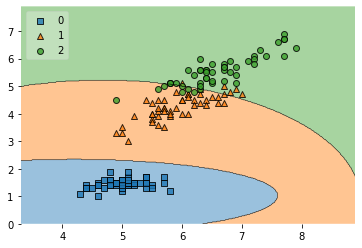

In [213]:
iris2dim = Classificador()
iris2dim.carregar('data/iris/iris2dim.csv', delimiter=',', ignoraLinha1=False)
iris2dim.treinar()
iris2dim.graficoFronteira()

In [46]:
modeloIris2dim = treinamento(iris2dim)

In [47]:
verificar(modeloIris2dim, [3.3, 1.0])

0.0

In [48]:
validacaoCruzada(iris2dim, 0.7)

Conj Teste: 45
Acertos   : 37
Acurácia  :  82.22222222222221


In [58]:
from mlxtend.plotting import plot_decision_regions

In [68]:
nb = Classificador()
nb.modelo = modeloIris2dim

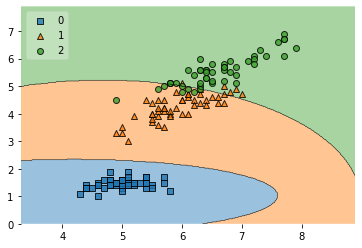

In [69]:
nb.graficoFronteira()a

In [51]:
import numpy as np

def graficoFronteiras(dados):
    
    X = np.array([ [float(x[0]),float(x[1])] for x in iris2dim ])
    y = np.array([ int(x[2]) for x in iris2dim ])
    
    #print('X',X)
    #print('y',y)
graficoFronteiras(iris2dim)

X [[7.2 6.1]
 [6.4 5.6]
 [5.7 1.7]
 [5.4 1.3]
 [6.9 5.1]
 [5.5 4.4]
 [7.9 6.4]
 [7.2 6. ]
 [5.9 5.1]
 [6.1 4.9]
 [6.1 4. ]
 [5.1 1.5]
 [7.7 6.1]
 [4.7 1.6]
 [5.1 1.9]
 [4.4 1.4]
 [5.7 4.5]
 [5.5 4. ]
 [4.9 1.5]
 [4.8 1.6]
 [7.7 6.7]
 [4.4 1.3]
 [6.7 4.7]
 [6.6 4.6]
 [6.9 5.7]
 [6.3 4.9]
 [5.9 4.2]
 [5.5 1.4]
 [5.  1.6]
 [5.1 1.6]
 [5.4 1.5]
 [5.  1.4]
 [5.8 1.2]
 [5.1 1.4]
 [5.8 5.1]
 [5.4 1.7]
 [6.5 5.1]
 [6.7 5. ]
 [6.4 4.5]
 [4.9 1.4]
 [6.  5.1]
 [5.5 3.7]
 [5.  1.3]
 [5.4 1.7]
 [7.4 6.1]
 [7.7 6.9]
 [6.3 5.6]
 [4.3 1.1]
 [6.4 4.3]
 [6.3 6. ]
 [6.2 4.8]
 [6.5 5.8]
 [5.2 1.5]
 [6.8 5.9]
 [5.2 3.9]
 [5.8 4. ]
 [4.6 1.4]
 [6.5 5.2]
 [6.7 5.8]
 [5.7 1.5]
 [4.4 1.3]
 [6.3 5. ]
 [5.8 4.1]
 [5.9 4.8]
 [6.  4.5]
 [6.3 4.9]
 [6.  4. ]
 [6.1 4.7]
 [4.8 1.6]
 [7.6 6.6]
 [5.  3.3]
 [5.4 1.5]
 [5.  3.5]
 [6.3 5.1]
 [7.3 6.3]
 [4.6 1.5]
 [5.7 4.2]
 [4.7 1.3]
 [6.2 5.4]
 [5.5 3.8]
 [5.8 5.1]
 [4.6 1.4]
 [4.9 1.5]
 [5.5 1.3]
 [4.8 1.4]
 [5.2 1.4]
 [6.8 5.5]
 [5.1 3. ]
 [5.7 4.1]
 [6.1 5.6]
 [6.2 4.

In [59]:
class Object(object):
    modelo = None
    
    def predict(self, tupla):
        res = []
        for t in tupla:
            res.append(int(verificar(self.modelo, t)))
        return(np.array(res))
    pass
nb = Object()
modeloIris2dim = treinamento(iris2dim)
nb.modelo = modeloIris2dim

In [305]:
res01 = nb.predict([[3.3 ,       1.0        ],
 [3.31299304, 1.        ],
 [3.32598608, 1.        ]])
type(res01)

numpy.ndarray

In [283]:
res = svm.predict([[3.3 ,       1.0        ],
 [3.31299304, 1.        ],
 [3.32598608, 1.        ]])

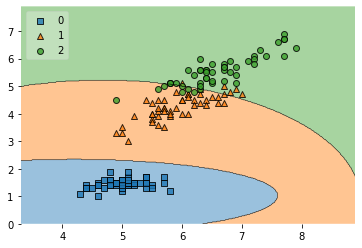

In [329]:
plot_decision_regions(X1, y1, clf=nb, legend=2)
#plt.xlabel('sepal length [cm]')
#plt.ylabel('petal length [cm]')
#plt.title('NB on Iris')
plt.show()

In [309]:
iris2dim

[('5.1', '1.4', '0'),
 ('4.9', '1.4', '0'),
 ('4.7', '1.3', '0'),
 ('4.6', '1.5', '0'),
 ('5.0', '1.4', '0'),
 ('5.4', '1.7', '0'),
 ('4.6', '1.4', '0'),
 ('5.0', '1.5', '0'),
 ('4.4', '1.4', '0'),
 ('4.9', '1.5', '0'),
 ('5.4', '1.5', '0'),
 ('4.8', '1.6', '0'),
 ('4.8', '1.4', '0'),
 ('4.3', '1.1', '0'),
 ('5.8', '1.2', '0'),
 ('5.7', '1.5', '0'),
 ('5.4', '1.3', '0'),
 ('5.1', '1.4', '0'),
 ('5.7', '1.7', '0'),
 ('5.1', '1.5', '0'),
 ('5.4', '1.7', '0'),
 ('5.1', '1.5', '0'),
 ('4.6', '1.0', '0'),
 ('5.1', '1.7', '0'),
 ('4.8', '1.9', '0'),
 ('5.0', '1.6', '0'),
 ('5.0', '1.6', '0'),
 ('5.2', '1.5', '0'),
 ('5.2', '1.4', '0'),
 ('4.7', '1.6', '0'),
 ('4.8', '1.6', '0'),
 ('5.4', '1.5', '0'),
 ('5.2', '1.5', '0'),
 ('5.5', '1.4', '0'),
 ('4.9', '1.5', '0'),
 ('5.0', '1.2', '0'),
 ('5.5', '1.3', '0'),
 ('4.9', '1.5', '0'),
 ('4.4', '1.3', '0'),
 ('5.1', '1.5', '0'),
 ('5.0', '1.3', '0'),
 ('4.5', '1.3', '0'),
 ('4.4', '1.3', '0'),
 ('5.0', '1.6', '0'),
 ('5.1', '1.9', '0'),
 ('4.8', '

In [284]:
type(res)

numpy.ndarray

In [184]:
nb.modelo = modeloIris
tupla = ('6.7', '3.3', '5.7', '2.5')
nb.predict(tupla)

'Iris-virginica'

In [322]:
X1 = np.array([ [float(x[0]),float(x[1])] for x in iris2dim ])
y1 = np.array([ int(x[2]) for x in iris2dim ])

In [323]:
X1

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3],
       [4.6, 1.5],
       [5. , 1.4],
       [5.4, 1.7],
       [4.6, 1.4],
       [5. , 1.5],
       [4.4, 1.4],
       [4.9, 1.5],
       [5.4, 1.5],
       [4.8, 1.6],
       [4.8, 1.4],
       [4.3, 1.1],
       [5.8, 1.2],
       [5.7, 1.5],
       [5.4, 1.3],
       [5.1, 1.4],
       [5.7, 1.7],
       [5.1, 1.5],
       [5.4, 1.7],
       [5.1, 1.5],
       [4.6, 1. ],
       [5.1, 1.7],
       [4.8, 1.9],
       [5. , 1.6],
       [5. , 1.6],
       [5.2, 1.5],
       [5.2, 1.4],
       [4.7, 1.6],
       [4.8, 1.6],
       [5.4, 1.5],
       [5.2, 1.5],
       [5.5, 1.4],
       [4.9, 1.5],
       [5. , 1.2],
       [5.5, 1.3],
       [4.9, 1.5],
       [4.4, 1.3],
       [5.1, 1.5],
       [5. , 1.3],
       [4.5, 1.3],
       [4.4, 1.3],
       [5. , 1.6],
       [5.1, 1.9],
       [4.8, 1.4],
       [5.1, 1.6],
       [4.6, 1.4],
       [5.3, 1.5],
       [5. , 1.4],
       [7. , 4.7],
       [6.4, 4.5],
       [6.9,

In [324]:
y1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [307]:
X

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1],
       [5.4, 3.7],
       [4.8, 3.4],
       [4.8, 3. ],
       [4.3, 3. ],
       [5.8, 4. ],
       [5.7, 4.4],
       [5.4, 3.9],
       [5.1, 3.5],
       [5.7, 3.8],
       [5.1, 3.8],
       [5.4, 3.4],
       [5.1, 3.7],
       [4.6, 3.6],
       [5.1, 3.3],
       [4.8, 3.4],
       [5. , 3. ],
       [5. , 3.4],
       [5.2, 3.5],
       [5.2, 3.4],
       [4.7, 3.2],
       [4.8, 3.1],
       [5.4, 3.4],
       [5.2, 4.1],
       [5.5, 4.2],
       [4.9, 3.1],
       [5. , 3.2],
       [5.5, 3.5],
       [4.9, 3.6],
       [4.4, 3. ],
       [5.1, 3.4],
       [5. , 3.5],
       [4.5, 2.3],
       [4.4, 3.2],
       [5. , 3.5],
       [5.1, 3.8],
       [4.8, 3. ],
       [5.1, 3.8],
       [4.6, 3.2],
       [5.3, 3.7],
       [5. , 3.3],
       [7. , 3.2],
       [6.4, 3.2],
       [6.9,

In [308]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# mlbench.cassini

In [330]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.cassini(500), 'data/cassini500.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.cassini(500), 'data/cassini500.csv')
> 
> 


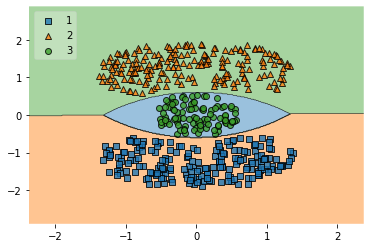

In [214]:
cassini = Classificador()
cassini.carregar('data/cassini500.csv', delimiter=',', ignoraColuna1=True)
cassini.treinar()
cassini.graficoFronteira()

In [363]:
validacaoCruzada(cassini, 0.5)

Conj Teste: 250
Acertos   : 250
Acurácia  :  100.0


# mlbench.circle

In [122]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.circle(200), 'data/circle200.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.circle(200), 'data/circle200.csv')
> 
> 


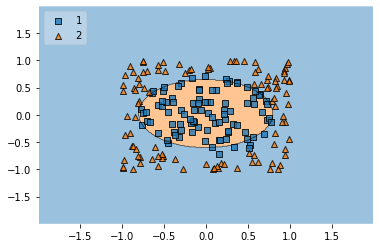

In [215]:
circle = Classificador()
circle.carregar('data/circle200.csv', delimiter=',', ignoraColuna1=True)
circle.treinar()
circle.graficoFronteira()

# mlbench.hypercube

In [256]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.hypercube(500, 2), 'data/hypercube.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.hypercube(500, 2), 'data/hypercube.csv')
> 
> 


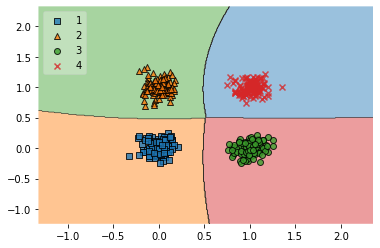

In [257]:
clf = Classificador()
clf.carregar('data/hypercube.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.ringnorm

In [259]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.ringnorm(500,2), 'data/ringnorm.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.ringnorm(500,2), 'data/ringnorm.csv')
> 
> 


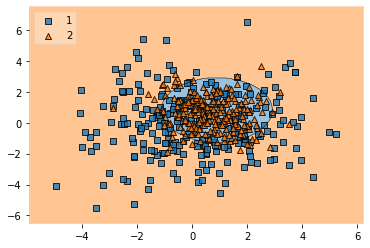

In [260]:
clf = Classificador()
clf.carregar('data/ringnorm.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.shapes

In [135]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.shapes(500), 'data/shapes.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.shapes(500), 'data/shapes.csv')
> 
> 


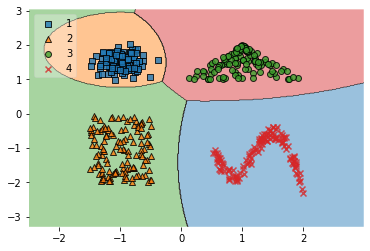

In [224]:
clf = Classificador()
clf.carregar('data/shapes.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.simplex

In [241]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.simplex(500, 2), 'data/simplex.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.simplex(500, 2), 'data/simplex.csv')
> 
> 


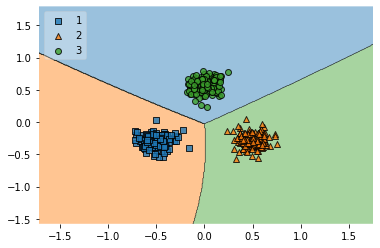

In [243]:
clf = Classificador()
clf.carregar('data/simplex.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.smiley

In [140]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.smiley(500), 'data/smiley.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.smiley(500), 'data/smiley.csv')
> 
> 


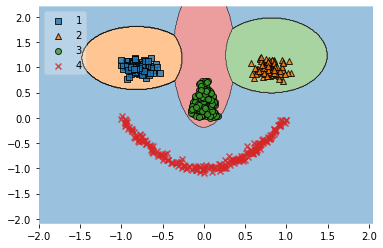

In [228]:
clf = Classificador()
clf.carregar('data/smiley.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.spirals

In [142]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.spirals(500), 'data/spirals.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.spirals(500), 'data/spirals.csv')
> 
> 


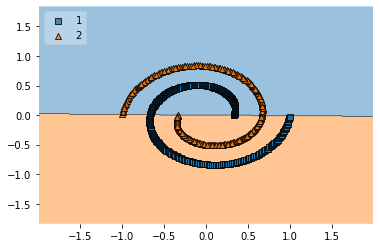

In [229]:
clf = Classificador()
clf.carregar('data/spirals.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.spirals

In [240]:
#### baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.spirals(1000, 4), 'data/spirals2.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.spirals(1000, 4), 'data/spirals2.csv')
> 
> 


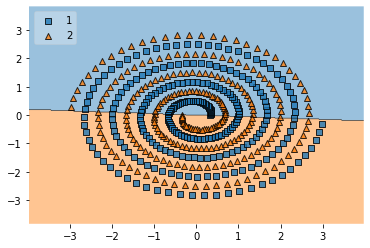

In [239]:
clf = Classificador()
clf.carregar('data/spirals2.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.threenorm

In [232]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.threenorm(500, 2), 'data/threenorm.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.threenorm(500, 2), 'data/threenorm.csv')
> 
> 


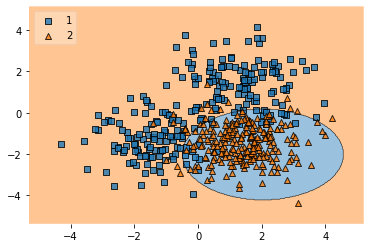

In [234]:
clf = Classificador()
clf.carregar('data/threenorm.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.twonorm

In [261]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.twonorm(500, 2), 'data/twonorm.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.twonorm(500, 2), 'data/twonorm.csv')
> 
> 


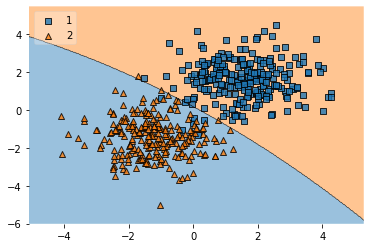

In [262]:
clf = Classificador()
clf.carregar('data/twonorm.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()

# mlbench.xor

In [268]:
# baixando dataset do R
!R -e "library(mlbench); write.csv(mlbench.xor(500, d=2), 'data/xor2d.csv')"


R version 3.6.3 (2020-02-29) -- "Holding the Windsock"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R é um software livre e vem sem GARANTIA ALGUMA.
Você pode redistribuí-lo sob certas circunstâncias.
Digite 'license()' ou 'licence()' para detalhes de distribuição.

R é um projeto colaborativo com muitos contribuidores.
Digite 'contributors()' para obter mais informações e
'citation()' para saber como citar o R ou pacotes do R em publicações.

Digite 'demo()' para demonstrações, 'help()' para o sistema on-line de ajuda,
ou 'help.start()' para abrir o sistema de ajuda em HTML no seu navegador.
Digite 'q()' para sair do R.

> library(mlbench); write.csv(mlbench.xor(500, d=2), 'data/xor2d.csv')
> 
> 


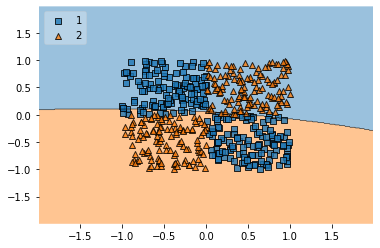

In [276]:
clf = Classificador()
clf.carregar('data/xor2d.csv', delimiter=',', ignoraColuna1=True)
clf.treinar()
clf.graficoFronteira()